# Problem 8.8 — Markov Switching Regression Model

Consider the Markov switching model

$$X_t = \mu_{S_t} + X_{t-1}\beta_{S_t} + \varepsilon_t, \quad \varepsilon_t \sim \text{WN}(0, \sigma_{S_t}^2)$$

Use the Python function `MarkovRegression` to fit the model to the dataset in Example 8.8. Are you satisfied with your results?

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from PythonTsa.LjungBoxtest import plot_LB_pvalue
from statsmodels.tsa.regime_switching.tests.test_markov_regression import areturns

# Global style: transparent background, no grid
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['axes.grid'] = False
plt.rcParams['legend.framealpha'] = 0

## 1. Data Preparation

In [2]:
index = pd.date_range("2004-05-04", "2014-5-03", freq="W")
dta_areturns = pd.Series(areturns, index=index)
print(f"Number of observations: {len(dta_areturns)}")
print(dta_areturns.describe())

Number of observations: 521
count    521.000000
mean       1.391314
std        1.395159
min        0.003104
25%        0.474185
50%        1.022084
75%        1.877938
max       10.321892
dtype: float64


## 2. Time Series Plot of Absolute Returns

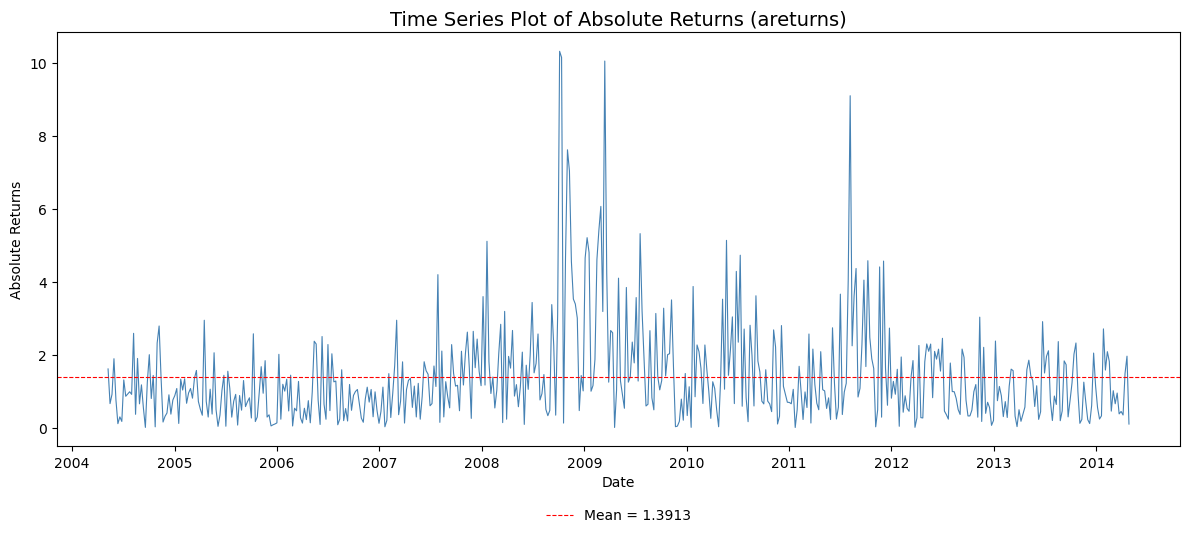

In [3]:
fig, ax = plt.subplots(figsize=(12, 5.5))
ax.plot(dta_areturns, color='steelblue', linewidth=0.8)
ax.set_title('Time Series Plot of Absolute Returns (areturns)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Absolute Returns')
ax.axhline(y=dta_areturns.mean(), color='red', linestyle='--', linewidth=0.8, label=f'Mean = {dta_areturns.mean():.4f}')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1)
plt.tight_layout()
plt.show()

## 3. Histogram and Q-Q Plot of Absolute Returns

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


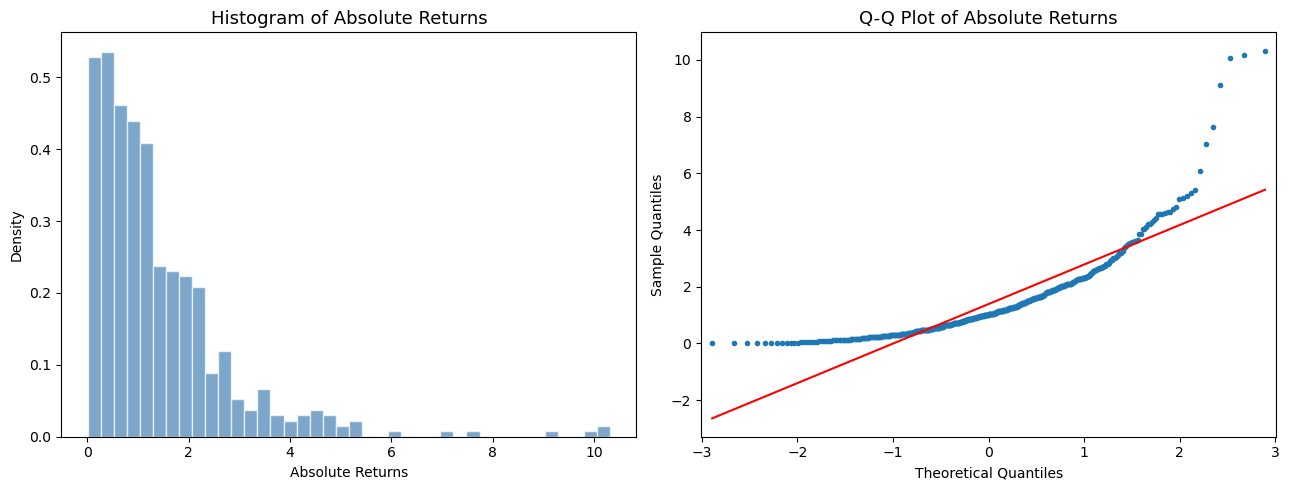

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(dta_areturns, bins=40, color='steelblue', edgecolor='white', density=True, alpha=0.7)
axes[0].set_title('Histogram of Absolute Returns', fontsize=13)
axes[0].set_xlabel('Absolute Returns')
axes[0].set_ylabel('Density')

sm.qqplot(dta_areturns.values, line='s', ax=axes[1], color='steelblue', markersize=3)
axes[1].set_title('Q-Q Plot of Absolute Returns', fontsize=13)

plt.tight_layout()
plt.show()

## 4. ACF and PACF of Absolute Returns

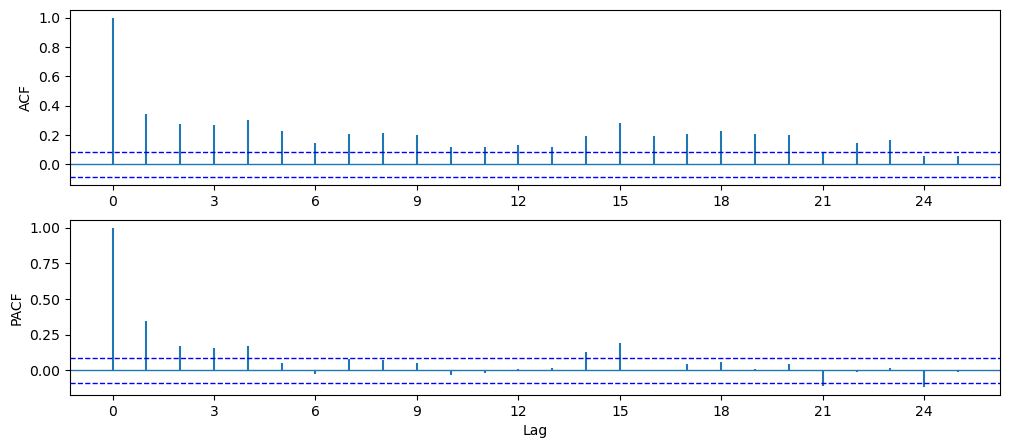

In [5]:
acf_pacf_fig(dta_areturns, both=True, lag=25)
plt.show()

## 5. Create Lagged Variable and Fit Markov Switching Model

In [6]:
areturnslag = dta_areturns.shift(1)
del areturnslag['2004-05-09']
del dta_areturns['2004-05-09']

In [7]:
mod = sm.tsa.MarkovRegression(
    endog=dta_areturns, k_regimes=2,
    exog=areturnslag, order=0, switching_variance=True
)
myfit = mod.fit()
print(myfit.summary())

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  520
Model:               MarkovRegression   Log Likelihood                -745.798
Date:                Tue, 10 Feb 2026   AIC                           1507.595
Time:                        21:29:36   BIC                           1541.626
Sample:                    05-16-2004   HQIC                          1520.926
                         - 04-27-2014                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7641      0.078      9.761      0.000       0.611       0.918
x1             0.0791      0.030      2.620      0.0

## 6. Estimated Regime Parameters

In [8]:
params = myfit.params
print('Regime 0 (low variance) parameters:')
print(f'  const  = {params["const[0]"]:.4f}')
print(f'  x1     = {params["x1[0]"]:.4f}')
print(f'  sigma2 = {params["sigma2[0]"]:.4f}')
print()
print('Regime 1 (high variance) parameters:')
print(f'  const  = {params["const[1]"]:.4f}')
print(f'  x1     = {params["x1[1]"]:.4f}')
print(f'  sigma2 = {params["sigma2[1]"]:.4f}')
print(f'\nVariance ratio (Regime1/Regime0): {params["sigma2[1]"]/params["sigma2[0]"]:.2f}')

Regime 0 (low variance) parameters:
  const  = 0.7641
  x1     = 0.0791
  sigma2 = 0.3476

Regime 1 (high variance) parameters:
  const  = 1.9728
  x1     = 0.5280
  sigma2 = 2.5771

Variance ratio (Regime1/Regime0): 7.41


## 7. Transition Matrix and Expected Durations

In [9]:
print('Transition Matrix:')
print(pd.DataFrame(np.squeeze(myfit.regime_transition), 
                    index=['To Regime 0', 'To Regime 1'],
                    columns=['From Regime 0', 'From Regime 1']))
print()
print('Expected Duration in Each Regime (weeks):')
print(myfit.expected_durations)

Transition Matrix:
             From Regime 0  From Regime 1
To Regime 0       0.753079       0.682539
To Regime 1       0.246921       0.317461

Expected Duration in Each Regime (weeks):
[4.04987708 1.46511719]


## 8. Smoothed Regime Probabilities

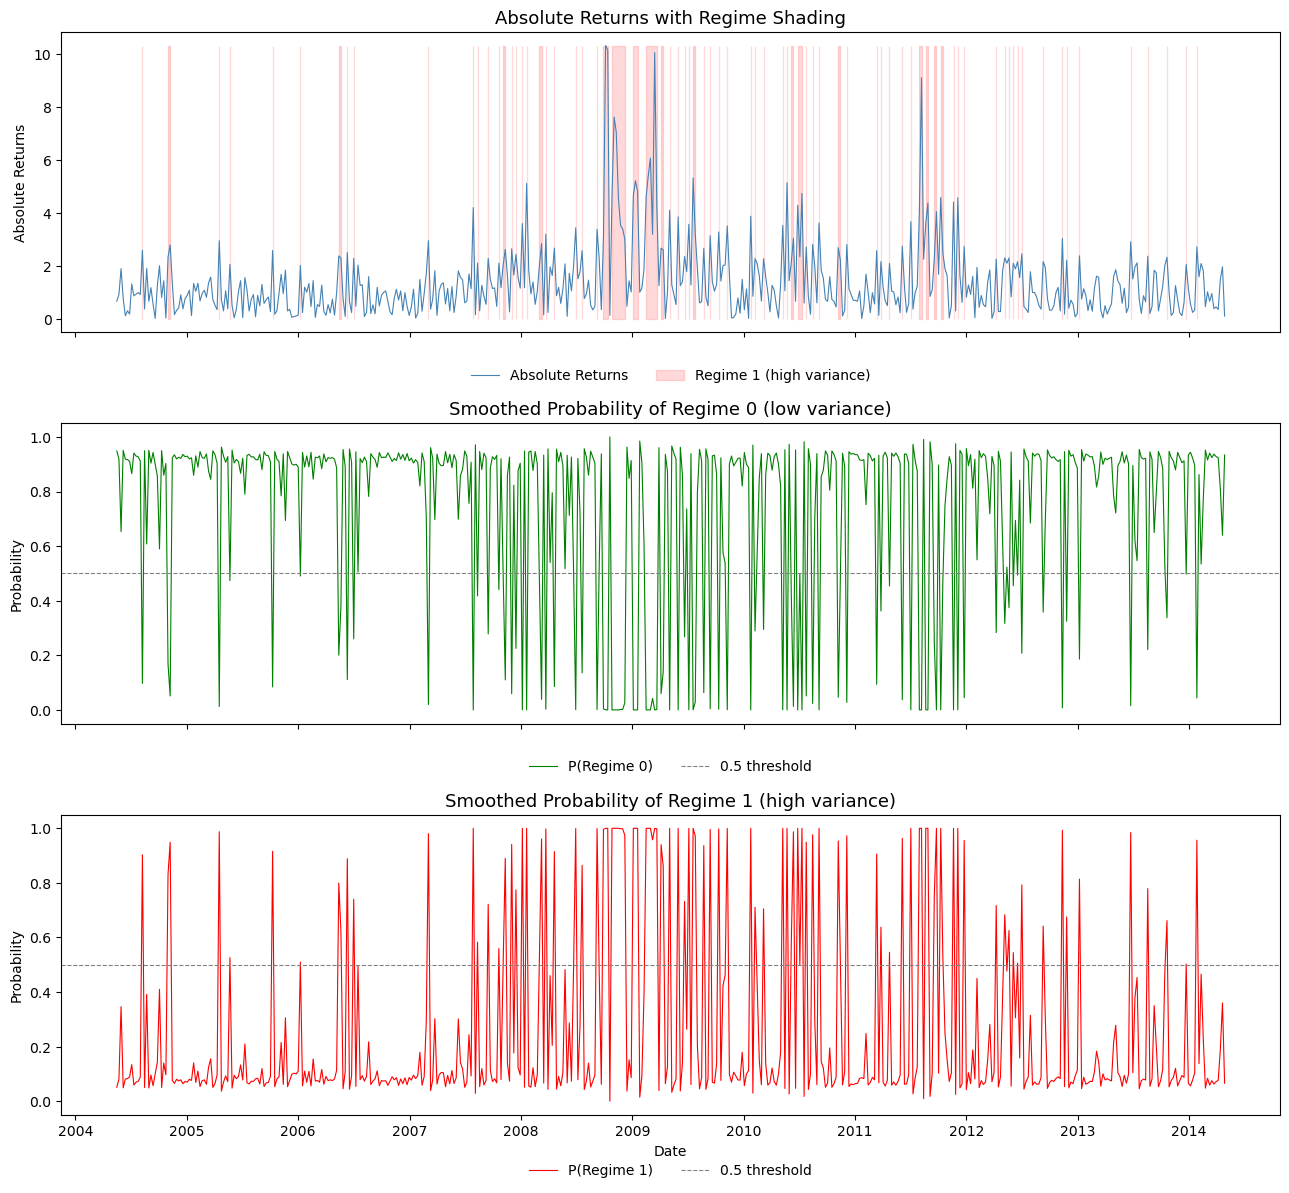

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(13, 12), sharex=True)

# Time series with regime shading
ax = axes[0]
ax.plot(dta_areturns, color='steelblue', linewidth=0.8, label='Absolute Returns')
ax.fill_between(dta_areturns.index, dta_areturns.min(), dta_areturns.max(),
                where=myfit.smoothed_marginal_probabilities[1] > 0.5,
                alpha=0.15, color='red', label='Regime 1 (high variance)')
ax.set_title('Absolute Returns with Regime Shading', fontsize=13)
ax.set_ylabel('Absolute Returns')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)

# Smoothed probability of Regime 0
ax = axes[1]
ax.plot(myfit.smoothed_marginal_probabilities[0], color='green', linewidth=0.8, label='P(Regime 0)')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8, label='0.5 threshold')
ax.set_title('Smoothed Probability of Regime 0 (low variance)', fontsize=13)
ax.set_ylabel('Probability')
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)

# Smoothed probability of Regime 1
ax = axes[2]
ax.plot(myfit.smoothed_marginal_probabilities[1], color='red', linewidth=0.8, label='P(Regime 1)')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8, label='0.5 threshold')
ax.set_title('Smoothed Probability of Regime 1 (high variance)', fontsize=13)
ax.set_ylabel('Probability')
ax.set_xlabel('Date')
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)

plt.tight_layout()
plt.show()

## 9. Filtered Regime Probabilities

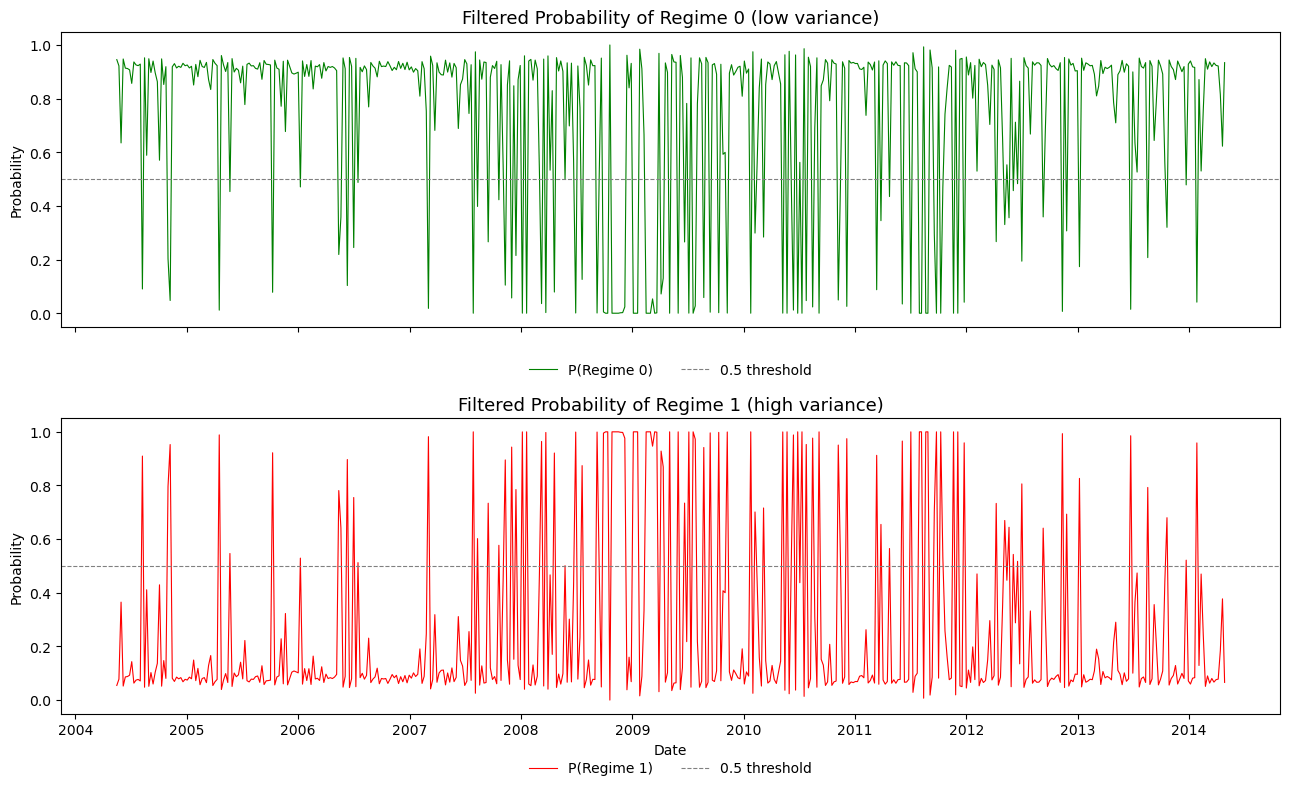

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

ax = axes[0]
ax.plot(myfit.filtered_marginal_probabilities[0], color='green', linewidth=0.8, label='P(Regime 0)')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8, label='0.5 threshold')
ax.set_title('Filtered Probability of Regime 0 (low variance)', fontsize=13)
ax.set_ylabel('Probability')
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)

ax = axes[1]
ax.plot(myfit.filtered_marginal_probabilities[1], color='red', linewidth=0.8, label='P(Regime 1)')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8, label='0.5 threshold')
ax.set_title('Filtered Probability of Regime 1 (high variance)', fontsize=13)
ax.set_ylabel('Probability')
ax.set_xlabel('Date')
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)

plt.tight_layout()
plt.show()

## 10. Regime Classification — Absolute Returns by Most Likely Regime

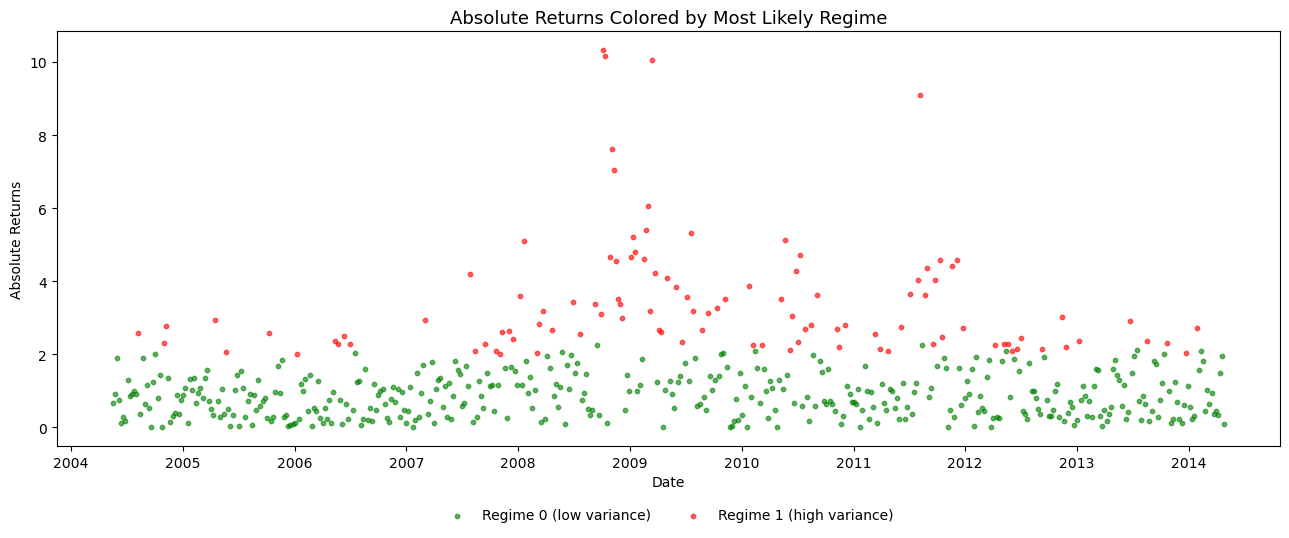

In [12]:
regime = (myfit.smoothed_marginal_probabilities[1] > 0.5).astype(int)
mask0 = regime == 0
mask1 = regime == 1

fig, ax = plt.subplots(figsize=(13, 5.5))
ax.scatter(dta_areturns.index[mask0], dta_areturns[mask0], c='green', s=10, alpha=0.6, label='Regime 0 (low variance)')
ax.scatter(dta_areturns.index[mask1], dta_areturns[mask1], c='red', s=10, alpha=0.6, label='Regime 1 (high variance)')
ax.set_title('Absolute Returns Colored by Most Likely Regime', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Absolute Returns')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.tight_layout()
plt.show()

## 11. Residual Analysis

In [13]:
myresid = myfit.resid

### Time Series Plot of Residuals

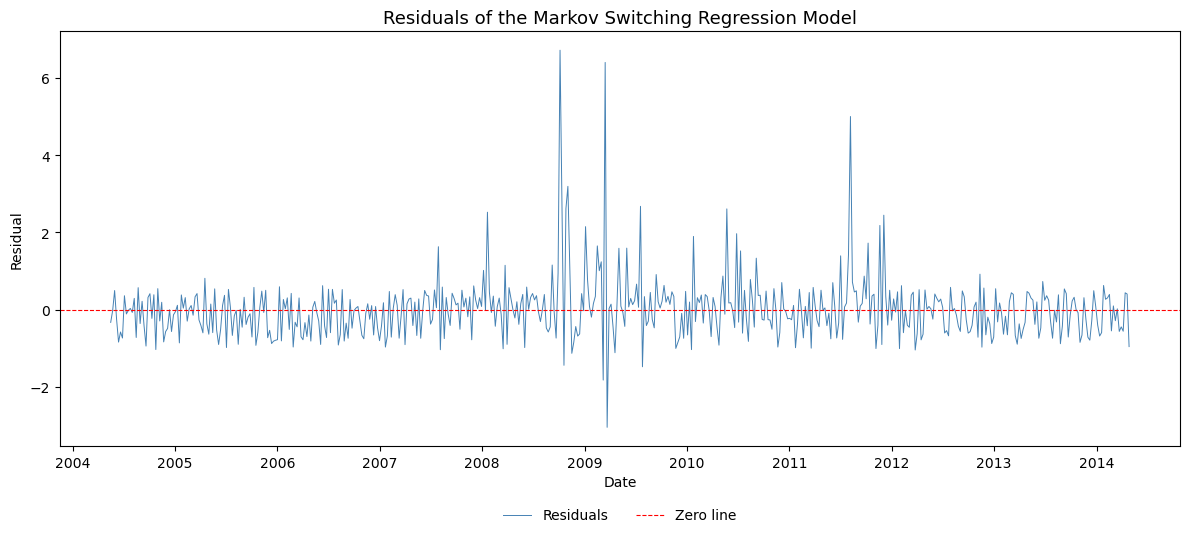

In [14]:
fig, ax = plt.subplots(figsize=(12, 5.5))
ax.plot(myresid, color='steelblue', linewidth=0.7, label='Residuals')
ax.set_title('Residuals of the Markov Switching Regression Model', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.axhline(y=0, color='red', linestyle='--', linewidth=0.8, label='Zero line')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.tight_layout()
plt.show()

### Histogram and Q-Q Plot of Residuals

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


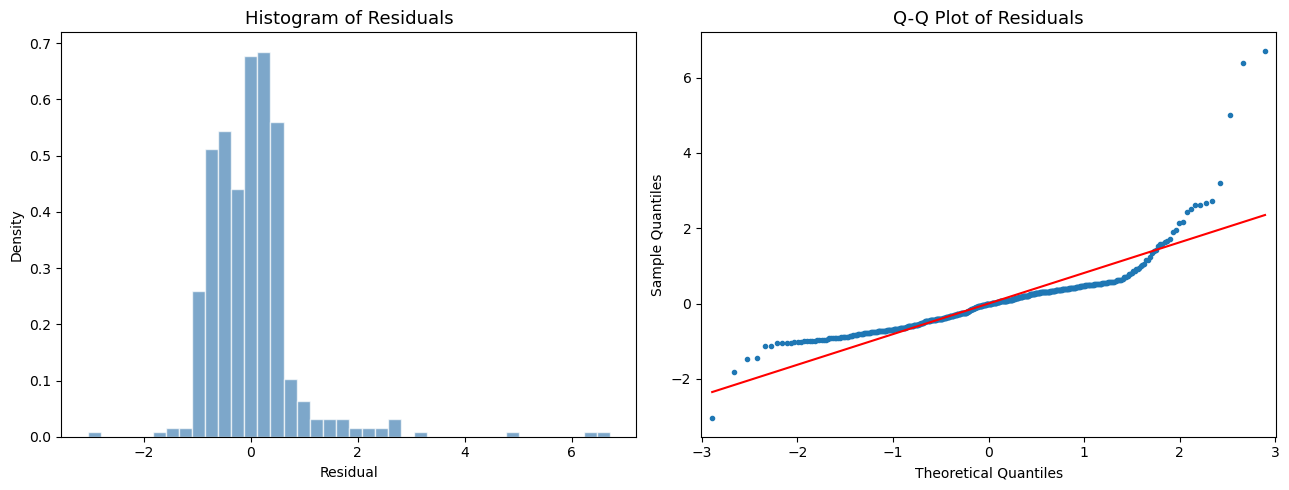

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(myresid, bins=40, color='steelblue', edgecolor='white', density=True, alpha=0.7)
axes[0].set_title('Histogram of Residuals', fontsize=13)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Density')

sm.qqplot(myresid.values, line='s', ax=axes[1], color='steelblue', markersize=3)
axes[1].set_title('Q-Q Plot of Residuals', fontsize=13)

plt.tight_layout()
plt.show()

### ACF and PACF of Residuals

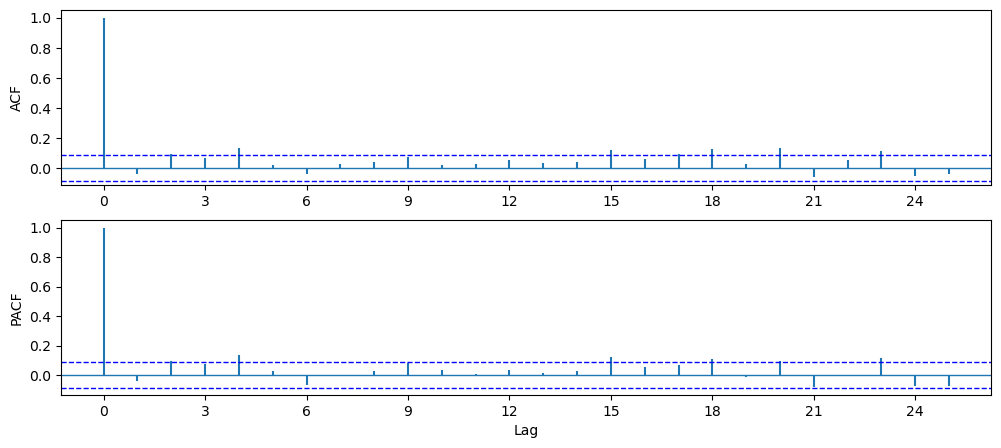

In [16]:
acf_pacf_fig(myresid, both=True, lag=25)
plt.show()

### P-Values for the Ljung-Box Test of Residuals

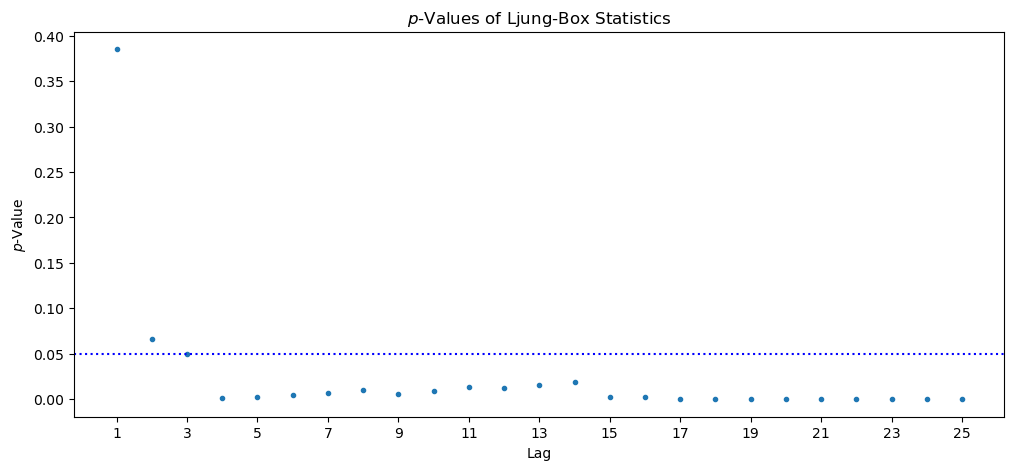

In [17]:
plot_LB_pvalue(myresid, noestimatedcoef=0, nolags=25)
plt.show()

### P-Values for the Ljung-Box Test of Squared Residuals (ARCH Effect)

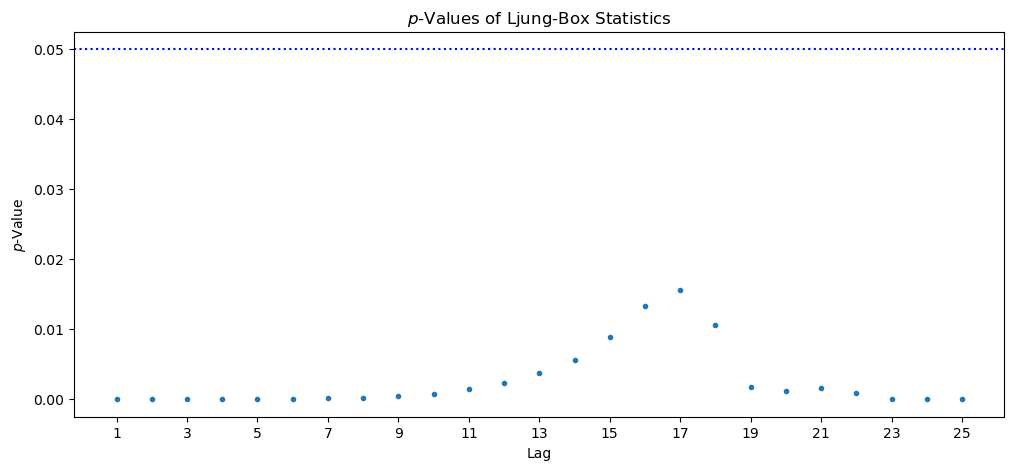

In [18]:
plot_LB_pvalue(myresid**2, noestimatedcoef=0, nolags=25)
plt.show()

## 12. Conclusion

The estimated Markov switching regression model appears fine at first glance — the two regimes capture different levels of volatility and persistence. However, observing the P-values for the Ljung-Box test of the residuals, most P-values are much smaller than 0.05, indicating that **the estimated model is inappropriate and unsatisfactory**. The residuals still exhibit significant serial correlation that the model fails to capture adequately.